In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurements = base.classes.measurement
Stations = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
sess = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
max_date1 = sess.query(Measurements.date).order_by(Measurements.date.desc()).first()
#Use DateTime on most recent date
max_date = datetime.strptime(max_date1[0], '%Y-%m-%d')
max_date

datetime.datetime(2017, 8, 23, 0, 0)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
#max_date
# Calculate the date one year from the last date in data set.
year_ago = max_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
precdata = sess.query(Measurements.date, Measurements.station, Measurements.prcp, Measurements.tobs)\
.filter(Measurements.date >= year_ago)

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
#NOTE: I prefered to have the date and prcp in their own columns in the dataframe.
#I did not reset the index to the date column
precframe = pd.read_sql_query(sql = precdata.statement,con = engine)
#Cleaned date in prcp column
precframe['prcp'] = precframe['prcp'].fillna(0)
# Sort the dataframe by date
prec_df1 = precframe.sort_values(by=['date'])
#Droped unnecessary columns.
prec_df = prec_df1.drop(['station','tobs'], axis = 1)
#Dataframe suitable for Pandas Ploting
prec_df

,date,prcp
0,2016-08-24,0.08
1006,2016-08-24,0.00
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
...,...,...
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00


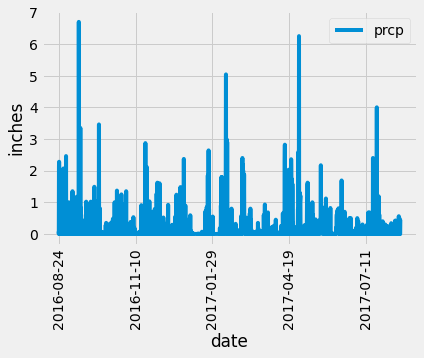

In [203]:
#Dataframe suitable for Pandas Ploting
prcpchart = prec_df.plot(x='date', rot=90, ylabel='inches')
plt.show()

In [137]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [153]:
# Design a query to calculate the total number stations in the dataset
station_n = sess.query(func.count(Stations.station))
#station_n[0]
station_number = ''.join(map(str, station_n[0]))
station_number
print(f'The number of stations is: {station_number}')

The number of stations is: 9


In [156]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_temp_counts = sess.query(Measurements.station, func.count(Measurements.station))\
.group_by(Measurements.station)\
.order_by(func.count(Measurements.station).desc())

for row in station_temp_counts:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [164]:
#Most Active Station
max_station = sess.query(Measurements.station)\
.group_by(Measurements.station)\
.order_by(func.count(Measurements.station).desc()).first()
# Use the index location to return only the value of max_station.
#The max_station variable can now be used in session queries.
max_station=max_station[0]
max_station

'USC00519281'

In [174]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#Minimum Temperature
min_temp_q = sess.query(func.min(Measurements.tobs)).filter(Measurements.station == max_station)
#Return only the value of min_temp_q in new variable
min_temp = ''.join(map(str, min_temp_q[0]))

#Maximum Temperature
max_temp_q = sess.query(func.max(Measurements.tobs)).filter(Measurements.station == max_station)
#Return only the value of max_temp_q in new variable
max_temp = ''.join(map(str, max_temp_q[0]))

#Average Temperature
avg_temp_q = sess.query(func.avg(Measurements.tobs)).filter(Measurements.station == max_station)
#Return only the value of avg_temp_q in new variable
avg_temp = ''.join(map(str, avg_temp_q[0]))
 # fprints for readability
print(f'For station {max_station}:')
print(f'The minimum reported temperature for the time frame was {min_temp}')
print(f'The maximum reported temperature for the time frame was {max_temp}')
print(f'The average reported temperature for the time frame was {avg_temp:.4}')

For station USC00519281:
The minimum reported temperature for the time frame was 54.0
The maximum reported temperature for the time frame was 85.0
The average reported temperature for the time frame was 71.6


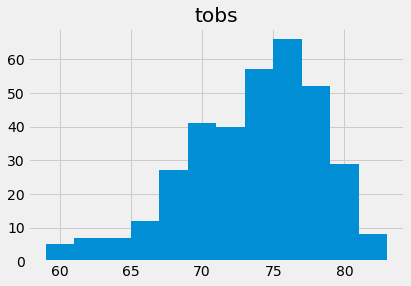

In [201]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_hist= sess.query(Measurements.station,Measurements.date,Measurements.prcp,Measurements.tobs)\
.filter(Measurements.station == max_station).filter(Measurements.date >= year_ago)
#Create DataFrame
station_hist_df = pd.read_sql_query(sql = station_hist.statement, con = engine)
#Create Histogram
station_hist_df.hist(column='tobs',bins=12)
plt.show()

# Close session

In [180]:
# Close Session
sess.close()